# Molecular Dynamics Simulation and Analysis in a Notebook

Python is the perfect glue language, with big emphasis on readability and an awesome ecosystem of packages for all kind of areas, ranging from web development or machine learning to the most interesting science. In this short tutorial, we will focus on molecular dynamics as provided by the [Omnia](http://www.omnia.md) project.

Omnia is a compilation of diverse packages for chemistry simulations, but its main pillar is [OpenMM](http://openmm.org/): “a toolkit for molecular simulation using high performance GPU code”. While written in C++/CUDA/OpenCL, it also offers rich APIs in Python. A good number of several other packages use OpenMM or provide additional functionalities, such as [pdbfixer](https://github.com/pandegroup/pdbfixer) (preparation and cleaning), [mdtraj](http://mdtraj.org/1.8.0/) or [pytraj](https://amber-md.github.io/pytraj/) (analysis), [nglview](http://arose.github.io/nglview/latest/) (visualization), [parmed](http://parmed.github.io/ParmEd/html/index.html) (converters between different MD programs) or [openmoltools](https://github.com/choderalab/openmoltools) (a bit of everything, actually).

We will use all of them at some point of the tutorial, outlined here:

**Part A**

1. Prepare an environment for MDs with conda
2. Download, clean and prepare structures from PDB
3. Set up an OpenMM MD simulation from scratch

**Part B**

1. Preview the MD movie in the notebook with nglview
2. MD Analysis with pytraj or mdtraj
3. Custom clustering with the scipy stack

----------------

# A.1 - Prepare the environment

First, create a new Python 3.7 environment and name it freely.

```
conda create -n openmm python=3.7
```

The following packages will be required along the tutorial:

- openmm
- mdtraj
- pdbfixer
- nglview
- parmed
- openmoltools

However, they are not provided in the standard (`defaults`) `conda` channels like `numpy` or `ipython`. They are hosted in the `omnia` channel, so we need to specify that with the `-c` switch:

```
!conda install -y -c omnia openmm mdtraj pdbfixer parmed openmoltools
```

`nglview` is not up-to-date in the omnia channel, but it is in `bioconda`:

```
!conda install -y -c bioconda nglview
!jupyter-nbextension enable nglview --py --user # only if it does not work
```

That's it! Now, try to import this packages to test if they are correctly installed.

# A.2 - Download and prepare your structure

_Disclaimer: This tutorial is not meant as a MD crash course, but as an exercise to play with Python capabilities in science. Hence, I am not trying to be very cautious about the MD simulation itself. We will use small structures that will allow us to progress rapidly with a modest computer. Remember, we don't care about the MD, only the setup process!_

To run a proper MD, we need to download the structure from some place (PDB, for example), but that's only the first step. Sometimes, the structures are not complete, or include wrong residue names. Some include non-natural residues! Depending on the origin of the files, hydrogens must be added, and depending on which kind of simulation we want to run, we might need to solvate the structure (ie, surround the molecule with a box of waters). While that can be easily attained with Chimera or another GUI programs, we are going to use Python tools... Just because.

Another benefit of learning this procedure is that you could automatize the same pipeline for hundreds of files... :)

So... First! Download the structure. `parmed` comes handy here.

In [1]:
import parmed as pmd
mol = pmd.download_PDB('1rfo')
mol.visualize()

NGLWidget(count=10)

`1RFO` is a trimer. Let's suppose we only want to run the MD with one of the monomers... Let's download the PDB with `mdtraj` (alternative possibility), meant for trajectory analysis, but also features a handy [selection language](http://mdtraj.org/latest/atom_selection.html).

In [3]:
import mdtraj as md
trimer = md.load_pdb('http://www.rcsb.org/pdb/files/1RFO.pdb')
trimer.topology # evaluate to obtain relevant info

/home/jrodriguez/.local/anaconda/envs/openmm/lib/python3.5/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


<mdtraj.Topology with 3 chains, 81 residues, 1296 atoms, 1314 bonds at 0x7f3acd0237b8>

In [5]:
# Select only the first chain
indices = trimer.topology.select('chainid 0')
monomer = trimer.atom_slice(indices)
monomer

<mdtraj.Trajectory with 10 frames, 432 atoms, 27 residues, without unitcells at 0x7f3acc77fb38>

In [6]:
# Check everything is OK
import nglview as nv
nv.show_mdtraj(monomer)

NGLWidget(count=10)

In [7]:
# Do we have hydrogens already?
monomer.top.select('element H')

array([  4,   5,   6,   7,   8,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  56,
        57,  58,  59,  60,  61,  62,  72,  73,  74,  75,  76,  77,  83,
        84,  85,  86,  87,  95,  96,  97,  98,  99, 100, 101, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 134, 135,
       136, 137, 142, 143, 144, 154, 155, 156, 157, 158, 159, 160, 161,
       167, 168, 169, 170, 171, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 200, 201, 202, 203, 204, 205, 206, 207, 208, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 263, 264, 265,
       266, 271, 272, 273, 283, 284, 285, 286, 287, 288, 303, 304, 305,
       306, 307, 308, 309, 310, 311, 312, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,
       347, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 36

So far, so good. Looks like the structure is ready! If it weren't, `pdbfixer` could be applied.

# A.3 - Set up an openMM calculation!

The `mdtraj` objects contain all the necessary information about the molecule we need: the topology and its coordinates. We only need to choose a forcefield and then some technical details of the simulation itself.

In [8]:
from simtk import unit
import simtk.openmm as mm
from simtk.openmm import app
from sys import stdout

# Molecule details - atoms, connectivity and positions
topology = monomer.top.to_openmm()
positions = monomer.xyz[0] # we only want the first 'frame' of the molecule; ie, one of the NMR models

# Simulation details - the 'rules' of the game
# In openMM, a simulation is built with a topology, its corresponding system and the integrator
forcefield = app.ForceField('amber99sbildn.xml', 'amber99_obc.xml')
system = forcefield.createSystem(topology, nonbondedMethod=app.CutoffNonPeriodic)
integrator = mm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 1.0*unit.femtoseconds)
simulation = app.Simulation(topology, system, integrator)

print('Setting initial positions')
simulation.context.setPositions(positions)

print('Minimizing...')
simulation.minimizeEnergy()

# What kind of info do we want back?
simulation.reporters.append(app.DCDReporter('trajectory_.dcd', 1000)) # the movie file
# some realtime data on the progress of the sim
simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, progress=True, remainingTime=True, 
    speed=True, totalSteps=1e5, separator='\t'))

simulation.context.setVelocitiesToTemperature(300*unit.kelvin) # Assign random but coherent vels

# Run the thing alrady!
simulation.step(1e5)



Setting initial positions
Minimizing...
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
1.0%	1000	-3912.419189453125	255.1403017417056	0	--
2.0%	2000	-3799.124755859375	283.11515822247424	582	0:14
3.0%	3000	-3674.298095703125	308.12782733174953	601	0:13
4.0%	4000	-3684.833740234375	295.1534053639397	607	0:13
5.0%	5000	-3806.055908203125	306.961528638708	609	0:13
6.0%	6000	-3845.111328125	310.67067889418325	594	0:13
7.0%	7000	-3695.0908203125	306.81679170725835	596	0:13
8.0%	8000	-3758.9013671875	298.61258497957044	597	0:13
9.0%	9000	-3632.8154296875	291.52349107897453	597	0:13
10.0%	10000	-3664.41162109375	310.9290248895392	597	0:13
11.0%	11000	-3773.478515625	299.13939652405037	597	0:12
12.0%	12000	-3664.970703125	302.67442193913104	578	0:13
13.0%	13000	-3647.97314453125	312.99146268667556	566	0:13
14.0%	14000	-3760.64306640625	301.47680143539657	553	0:13
15.0%	15000	-3659.640625	298.40482426590074	543	0:13
16.0%	16000	-3750.9033

# Play the trajectory

MDTraj is really useful for this kind of stuff! 

In [20]:
# Did we got it right?
traj = md.load_dcd('trajectory_.dcd',  top=monomer.top)
nv.show_mdtraj(traj)

NGLWidget(count=100)

In [23]:
traj = traj.superpose(traj)

In [27]:
rmsds = md.rmsd?

In [ ]:
rmsds = md.rmsd

In [28]:
rmsds = md.rmsd(traj, traj)
rmsds

array([0.        , 0.10928389, 0.11783434, 0.1477965 , 0.19208157,
       0.20257197, 0.20463501, 0.21371627, 0.25483242, 0.24471691,
       0.27025995, 0.25876102, 0.2832585 , 0.2617139 , 0.25740445,
       0.25476924, 0.2244741 , 0.22038634, 0.20579784, 0.23220263,
       0.23265488, 0.28972477, 0.2686142 , 0.27404445, 0.26306516,
       0.24396637, 0.25100985, 0.25079134, 0.28160116, 0.33680338,
       0.35687238, 0.364234  , 0.36811307, 0.3647071 , 0.3888069 ,
       0.40152544, 0.41966155, 0.40384197, 0.3899522 , 0.40278998,
       0.38256994, 0.35712883, 0.33154985, 0.35154703, 0.40081313,
       0.4147309 , 0.3863013 , 0.37033686, 0.37862107, 0.37823653,
       0.35164106, 0.35520852, 0.3524708 , 0.3472838 , 0.35470998,
       0.3879469 , 0.37487093, 0.32339868, 0.30009985, 0.29856536,
       0.34217384, 0.35833737, 0.32796285, 0.3331824 , 0.3324482 ,
       0.3189772 , 0.3352538 , 0.3428761 , 0.29553968, 0.24914207,
       0.25530547, 0.23184885, 0.23824449, 0.2624519 , 0.27939

In [29]:
from matplotlib import pyplot as plt
%matplotlib notebook

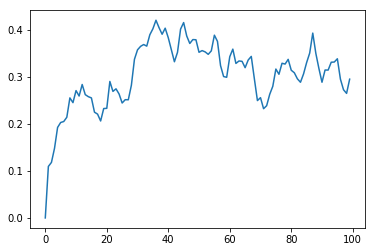

In [31]:
p = plt.plot(rmsds)